# Домашнее задание: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающего дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [2]:
p1 = 8/10
p2 = 2/10

H = p1 * math.log((1/p1),2) + p2 * math.log((1/p2),2)

print(round(H,2))

0.72


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [3]:
def index_gini(prob):
    return sum([p * (1 - p) for p in prob])

total_objects_m = 10
class_counts_m = [8, 2]
prob_m = [count / total_objects_m for count in class_counts_m]

total_objects_l = 8
class_counts_l = [8, 0]
prob_l = [count / total_objects_l for count in class_counts_l]

total_objects_r = 2
class_counts_r = [0, 2]
prob_r = [count / total_objects_r for count in class_counts_r]

H_Rm = index_gini(prob_m)
H_Rl = index_gini(prob_l)
H_Rr = index_gini(prob_r)

print("H(Rm) =", H_Rm)
print("H(Rl) =", H_Rl)
print("H(Rr) =", H_Rr)

P_left = total_objects_l / total_objects_m
P_right = total_objects_r / total_objects_m

Q = H_Rm - P_left * H_Rl - P_right * H_Rr

print("Q =", Q)

H(Rm) = 0.32
H(Rl) = 0.0
H(Rr) = 0.0
Q = 0.32


**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [4]:
target_values = [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]

mean_target = sum(target_values) / len(target_values)

print("Mean_target =", mean_target)

Mean_target = 40.6


## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [5]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [6]:
import numpy as np
import pandas as pd
from typing import Union, Tuple

def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:

    def _gini(y):
        counts = pd.Series(y).value_counts(normalize=True)
        return (counts * (1 - counts)).sum()

    def _dispersion(y):
        return pd.Series(y).std() ** 2

    def _information_gain(X, y, threshold):
        if feature_type == 'categorical':
            left = y[X == threshold]
            right = y[X != threshold]
        else:
            left = y[X <= threshold]
            right = y[X > threshold]

        if task == 'classification':
            S = _gini(y)
            S1 = _gini(left)
            S2 = _gini(right)
        else:
            S = _dispersion(y)
            S1 = _dispersion(left)
            S2 = _dispersion(right)

        n = len(y)
        ig = S - (len(left)/n)*S1 - (len(right)/n)*S2
        return ig if not np.isnan(ig) else 0

    unique = np.unique(feature_vector)

    if feature_type == 'real':
        thresholds = (unique[1:] + unique[:-1]) / 2
    else:
        thresholds = unique

    if len(unique) <= 1:
        return np.array([]), np.array([]), 0.0, 0.0

    X_series = pd.Series(feature_vector)
    y_series = pd.Series(target_vector)

    criterions = np.array([_information_gain(X_series, y_series, t) for t in thresholds])

    best_idx = np.argmax(criterions)
    return thresholds, criterions, thresholds[best_idx], criterions[best_idx]


Эту функцию можно протестировать на датасете `Boston` из `sklearn`.

Установим версию sklearn, которая содержит датасет Boston

In [7]:
!pip3 install fairlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 7.9 MB/s eta 0:00:00


In [8]:
from fairlearn.datasets import fetch_boston
X, y = fetch_boston(return_X_y=True)

thresholds, variances, threshold_best, variance_best = find_best_split(
    X["CRIM"].to_numpy(), y,
    task="regression", feature_type="real"
)


/usr/local/lib/python3.11/dist-packages/fairlearn/datasets/_fetch_boston.py:133: DataFairnessWarning: You are about to use a dataset with known fairness issues.
  warnings.warn(DataFairnessWarning(msg))


Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `CRIM`.

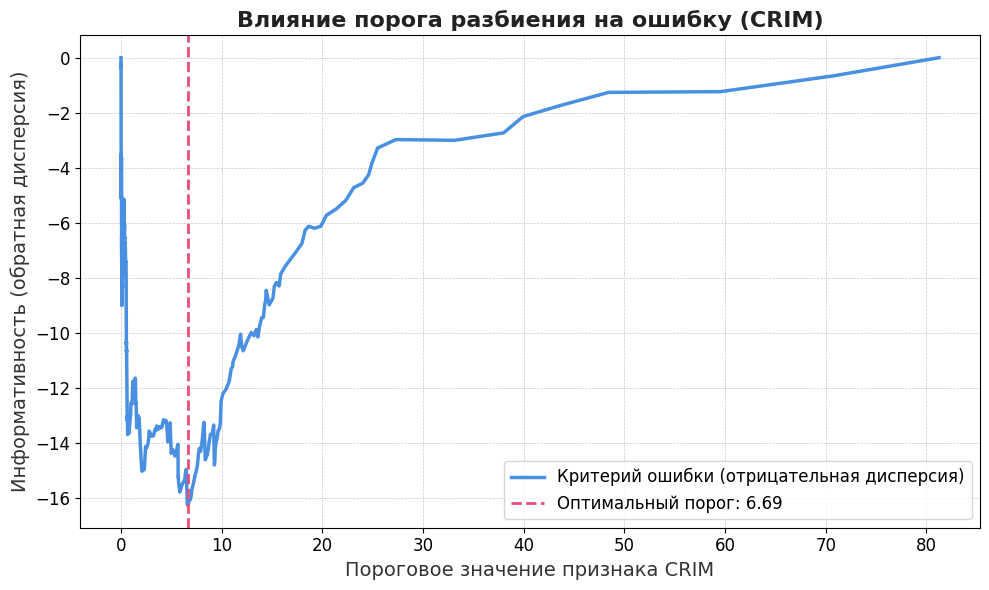

Оптимальный порог: 6.6863
Минимальная дисперсия: -16.2598


In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml

# Загрузка набора данных (замена устаревшего Boston)
boston = fetch_openml(name="boston", version=1, as_frame=True)
X = boston.data
y = boston.target.astype(float)


# Находим оптимальное разбиение
thresholds, variances, threshold_best, variance_best = find_best_split(
    X["CRIM"].values,
    y.values,
    task="regression",
    feature_type="real"
)

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(thresholds, -np.array(variances), color='#4A90E2', linewidth=2.5, label='Критерий ошибки (отрицательная дисперсия)')
plt.axvline(x=threshold_best, color='#E94E77', linestyle='--', linewidth=2.0, label=f'Оптимальный порог: {threshold_best:.2f}')
plt.xlabel('Пороговое значение признака CRIM', fontsize=14, fontweight='medium', color='#333333')
plt.ylabel('Информативность (обратная дисперсия)', fontsize=14, fontweight='medium', color='#333333')
plt.title('Влияние порога разбиения на ошибку (CRIM)', fontsize=16, fontweight='semibold', color='#222222')
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Выводим оптимальные значения
print(f"Оптимальный порог: {threshold_best:.4f}")
print(f"Минимальная дисперсия: {-variance_best:.4f}")


**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

In [10]:
class DecisionTree:

    def __init__(
        self,
        feature_types: Union[List[str], np.ndarray],
        max_depth: int = None,
        min_samples_split: int = None,
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:

        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}

        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types

        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

    def _fit_node(
        self,
        sub_X: np.ndarray,
        sub_y: np.ndarray,
        node: dict
    ) -> None:

        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)

            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector < threshold
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = feature_vector == threshold
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError

        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
        if node["type"] == "terminal":
            return node["class"]

        feature = node["feature_split"]
        if self._feature_types[feature] == "real":
            if x[feature] < node["threshold"]:
                return self._predict_node(x, node["left_child"])
            return self._predict_node(x, node["right_child"])
        else:
            if x[feature] == node["category_split"]:
                return self._predict_node(x, node["left_child"])
            return self._predict_node(x, node["right_child"])

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))

        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

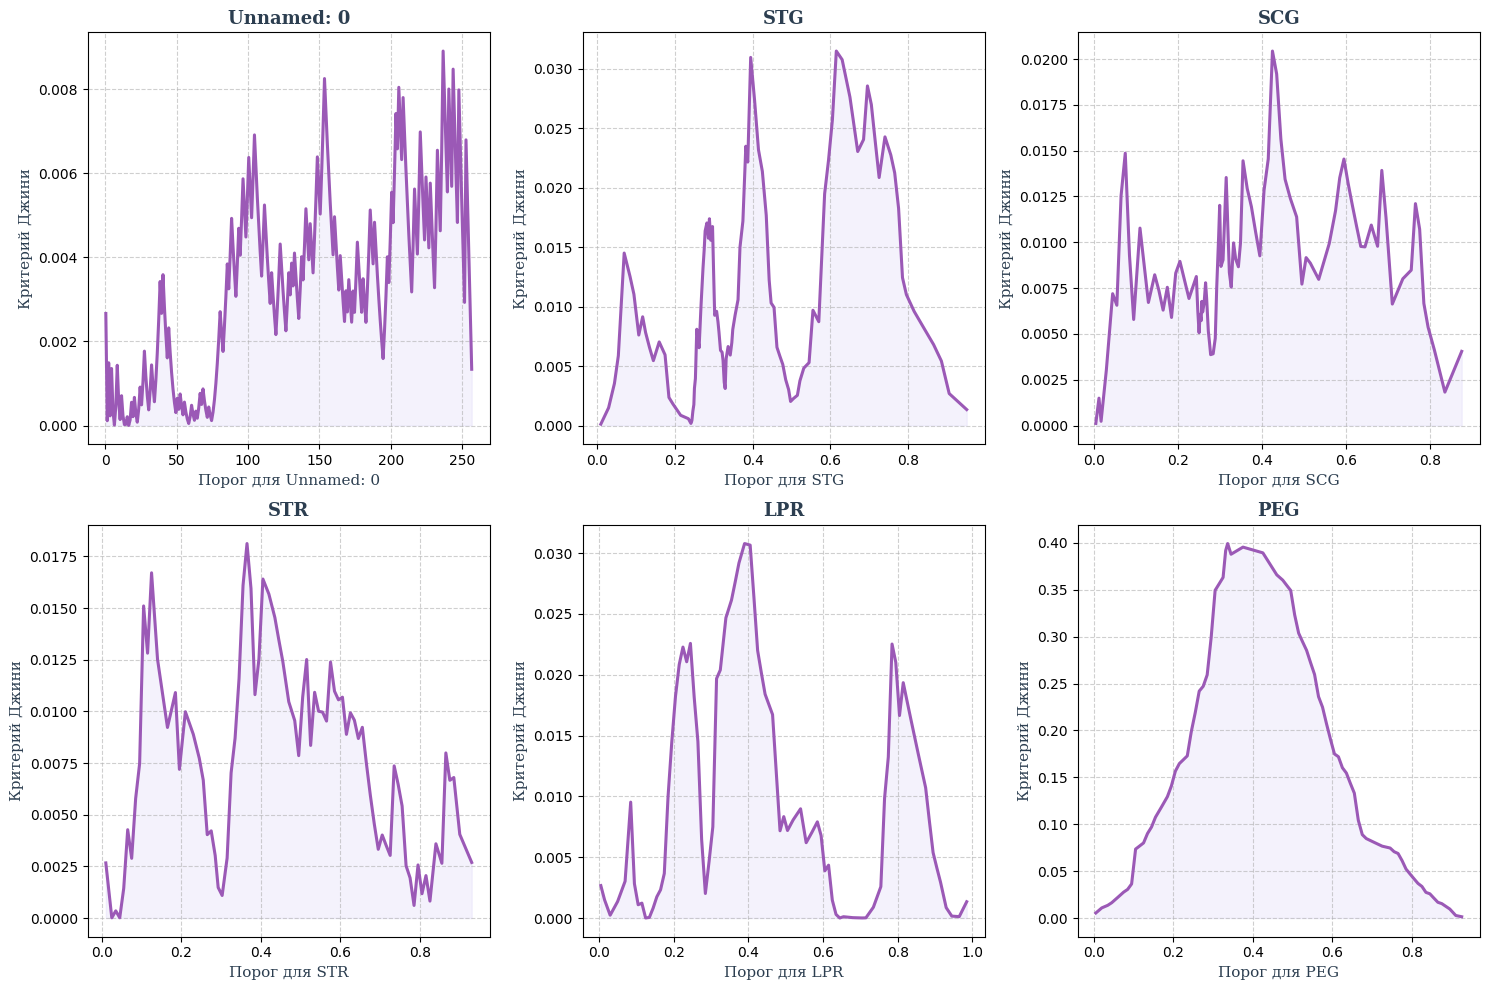

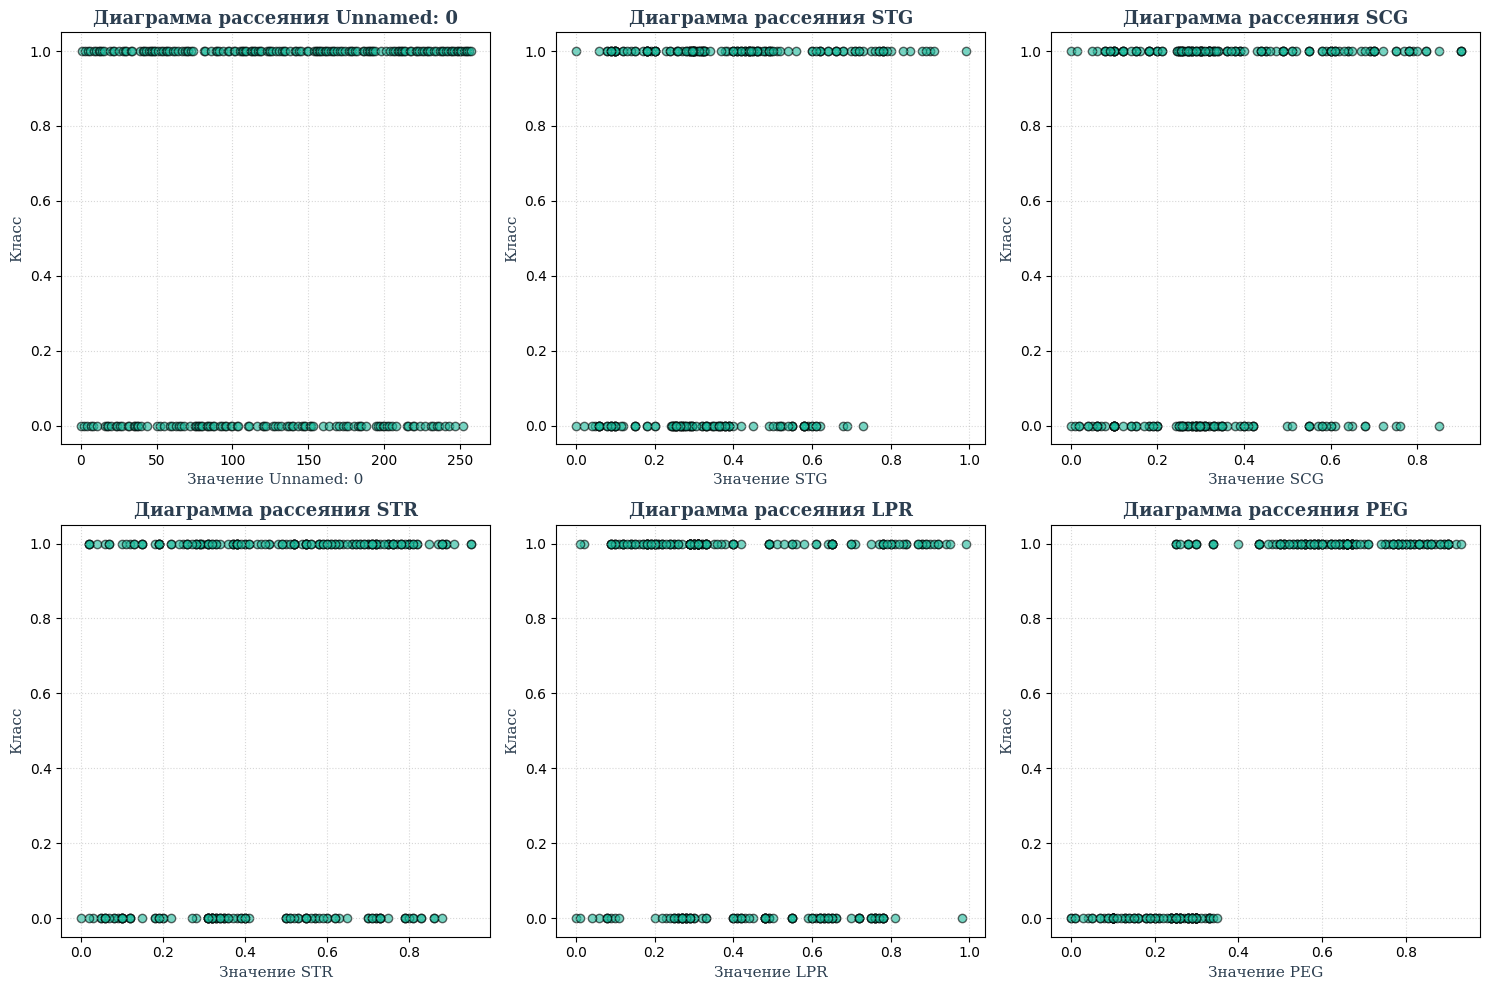

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

students = pd.read_csv('students.csv')
X = students.iloc[:, :-1]
y = students.iloc[:, -1]
features = X.columns

# Стилизация графиков с порогом и критерием Джини
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    feature_values = X[feature].values
    thresholds, ginis, _, _ = find_best_split(feature_values, y.values,
                                              task="classification",
                                              feature_type="real")
    plt.plot(thresholds, ginis, color='#9b59b6', linewidth=2.2)
    plt.fill_between(thresholds, ginis, color='#dcd6f7', alpha=0.3)
    plt.xlabel(f'Порог для {feature}', fontsize=11, fontname='serif', color='#2c3e50')
    plt.ylabel('Критерий Джини', fontsize=11, fontname='serif', color='#2c3e50')
    plt.title(f'{feature}', fontsize=13, fontweight='bold', fontname='serif', color='#2c3e50')
    plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# Диаграммы рассеяния — стиль
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    plt.scatter(X[feature], y, alpha=0.6, color='#1abc9c', edgecolors='k')
    plt.xlabel(f'Значение {feature}', fontsize=11, fontname='serif', color='#2c3e50')
    plt.ylabel('Класс', fontsize=11, fontname='serif', color='#2c3e50')
    plt.title(f'Диаграмма рассеяния {feature}', fontsize=13, fontweight='bold', fontname='serif', color='#2c3e50')
    plt.grid(True, linestyle=':', alpha=0.5)

plt.tight_layout()
plt.show()


Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

Оптимальный признак для разбиения - PEG (успешность на экзаменах), так как он демонстрирует наивысшее значение критерия Джини среди всех признаков.

Согласованность с визуализацией: диаграммы рассеяния подтверждают этот выбор, показывая четкую зависимость - пользователи с низкими результатами экзаменов (PEG) преимущественно относятся к классу 0 (низкий уровень знаний).

Характеристика хороших признаков:

График Джини имеет выраженную параболическую форму

Наблюдается четкий максимум с высоким значением критерия

Явно прослеживается точка оптимального разделения

Характеристика слабых признаков:

Кривая Джини практически плоская

Угол наклона графика минимален относительно оси X

Отсутствует выраженный максимум критерия

Разделение классов незначительное

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom).

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)),
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа.

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [13]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from collections import Counter

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
columns = ['class'] + [f'feature_{i}' for i in range(1, 23)]
data = pd.read_csv(url, header=None, names=columns)

le = LabelEncoder()
for col in data.columns:
    data[col] = le.fit_transform(data[col])

X = data.drop('class', axis=1).values
y = data['class'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

feature_types = ['categorical'] * X.shape[1]  # Все признаки категориальные
tree = DecisionTree(feature_types=feature_types, task='classification')
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 1.0000


## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [14]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [16]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

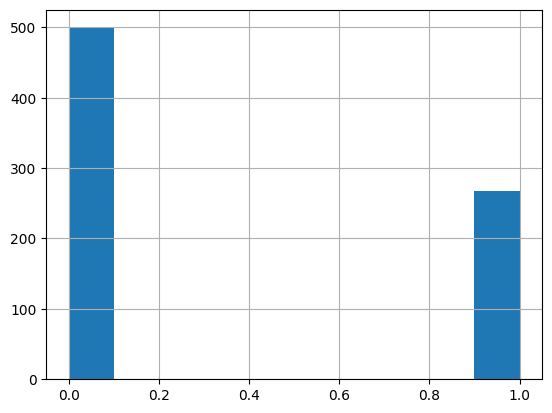

In [17]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

Размер обучающей-обучающей выборки: (375, 8)
Размер обучающей-валидационной выборки: (162, 8)
Размер тестовой выборки: (231, 8)


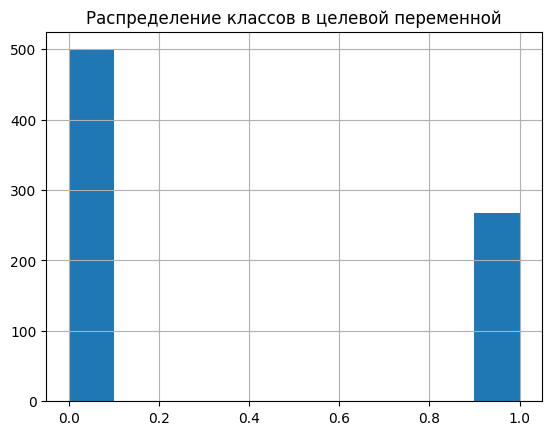

In [18]:
X = data.drop(columns='Outcome')
y = data['Outcome']

# Разбиваем исходные данные на тестовые и обучающие
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Из обучающей выборки создаем обучающую-обучающую и обучающую-валидационную выборки
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

# Выводим размерности выборок
print(f"Размер обучающей-обучающей выборки: {X_train_final.shape}")
print(f"Размер обучающей-валидационной выборки: {X_val.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

# Строим гистограмму для целевой переменной
data['Outcome'].hist()
plt.title('Распределение классов в целевой переменной')
plt.show()

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке.


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [19]:
from sklearn.metrics import f1_score

max_depth_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]
min_samples_leaf_values = [1, 2, 5, 10, 20]

best_f1 = 0
best_params = {}

# Перебор всех комбинаций гиперпараметров
for max_depth in max_depth_values:
    for min_samples_leaf in min_samples_leaf_values:
        model = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
        model.fit(X_train_final, y_train_final)

        # Оценка качества на валидационной выборке
        y_val_pred = model.predict(X_val)
        current_f1 = f1_score(y_val, y_val_pred)

        if current_f1 > best_f1:
            best_f1 = current_f1
            best_params = {'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf}

print(f"Лучшие параметры: {best_params}, F1-score на валидации: {best_f1}")

# Обучение дерева с оптимальными параметрами на полной обучающей выборке
final_model = DecisionTreeClassifier(max_depth=best_params['max_depth'], min_samples_leaf=best_params['min_samples_leaf'], random_state=42)
final_model.fit(X_train, y_train)

y_test_pred = final_model.predict(X_test)

print("Результаты на тестовой выборке:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"AUC ROC: {roc_auc_score(y_test, final_model.predict_proba(X_test)[:, 1]):.4f}")

Лучшие параметры: {'max_depth': 5, 'min_samples_leaf': 20}, F1-score на валидации: 0.625
Результаты на тестовой выборке:
Accuracy: 0.7273
Precision: 0.6452
Recall: 0.4938
AUC ROC: 0.7951


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [21]:
from sklearn.ensemble import BaggingClassifier

# Обучаем Bagging на основании дерева решений
bagging_classifier = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42), n_estimators=50, random_state=42)
bagging_classifier.fit(X_train_final, y_train_final)

# Прогнозируем результаты на тестовом наборе данных
y_pred_bagging = bagging_classifier.predict(X_test)

# Оцениваем производительность на тестовой выборке
print("Результаты на тестовой выборке после BaggingClassifier:")
print(f"Точность (Accuracy): {accuracy_score(y_test, y_pred_bagging):.4f}")
print(f"Точность (Precision): {precision_score(y_test, y_pred_bagging):.4f}")
print(f"Полнота (Recall): {recall_score(y_test, y_pred_bagging):.4f}")
print(f"AUC ROC: {roc_auc_score(y_test, bagging_classifier.predict_proba(X_test)[:, 1]):.4f}")

Результаты на тестовой выборке после BaggingClassifier:
Точность (Accuracy): 0.7792
Точность (Precision): 0.7586
Полнота (Recall): 0.5432
AUC ROC: 0.8307


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации.
3. Выберите ту пару значений, которая даёт наилучшее среднее качество.

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [22]:
from sklearn.model_selection import GridSearchCV

# Подготовка сетки гиперпараметров для подбора
param_grid = {
    'max_depth': [4, 6, 8, 10],
    'min_samples_split': [2, 5, 10]
}

# Создаем модель случайного леса
rf_classifier = RandomForestClassifier(n_estimators=50, random_state=42)

# Настройка и выполнение GridSearch
grid_search_cv = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search_cv.fit(X_train_final, y_train_final)

# Извлечение лучших гиперпараметров
optimal_params = grid_search_cv.best_params_
print(f"Лучшие найденные параметры для случайного леса: {optimal_params}")

# Обучение модели случайного леса с найденными гиперпараметрами
optimized_rf_model = RandomForestClassifier(n_estimators=50, **optimal_params, random_state=42)
optimized_rf_model.fit(X_train_final, y_train_final)

# Прогнозы на тестовой выборке с оптимизированной моделью
y_pred_rf = optimized_rf_model.predict(X_test)

# Оценка качества классификации
print("Результаты Random Forest на тестовой выборке:")
print(f"Точность (Accuracy): {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Точность (Precision): {precision_score(y_test, y_pred_rf):.4f}")
print(f"Полнота (Recall): {recall_score(y_test, y_pred_rf):.4f}")
print(f"AUC ROC: {roc_auc_score(y_test, optimized_rf_model.predict_proba(X_test)[:, 1]):.4f}")

Лучшие найденные параметры для случайного леса: {'max_depth': 10, 'min_samples_split': 10}
Результаты Random Forest на тестовой выборке:
Точность (Accuracy): 0.7576
Точность (Precision): 0.7119
Полнота (Recall): 0.5185
AUC ROC: 0.8385


**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

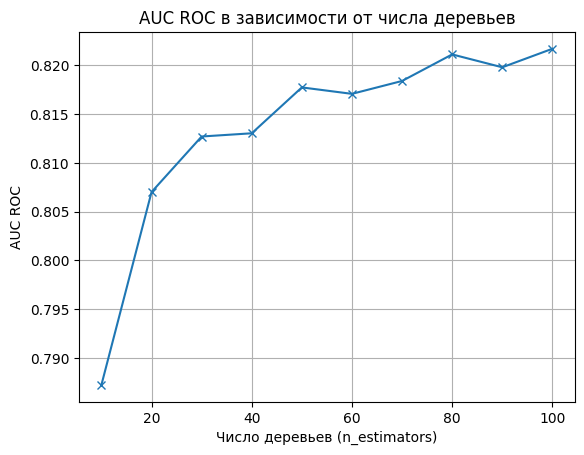

In [23]:
from sklearn.ensemble import BaggingClassifier

# Задаем диапазон для количества деревьев
n_estimators_values = np.arange(10, 101, 10)
auc_results = []

# Обучаем случайный лес для каждого значения n_estimators
for n_trees in n_estimators_values:
    forest_model = RandomForestClassifier(n_estimators=n_trees, **optimal_params, random_state=42)
    forest_model.fit(X_train, y_train)
    auc_score = roc_auc_score(y_test, forest_model.predict_proba(X_test)[:, 1])
    auc_results.append(auc_score)

# Создаем график AUC ROC
plt.plot(n_estimators_values, auc_results, marker='x')
plt.title('AUC ROC в зависимости от числа деревьев')
plt.xlabel('Число деревьев (n_estimators)')
plt.ylabel('AUC ROC')
plt.grid(True)
plt.show()

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

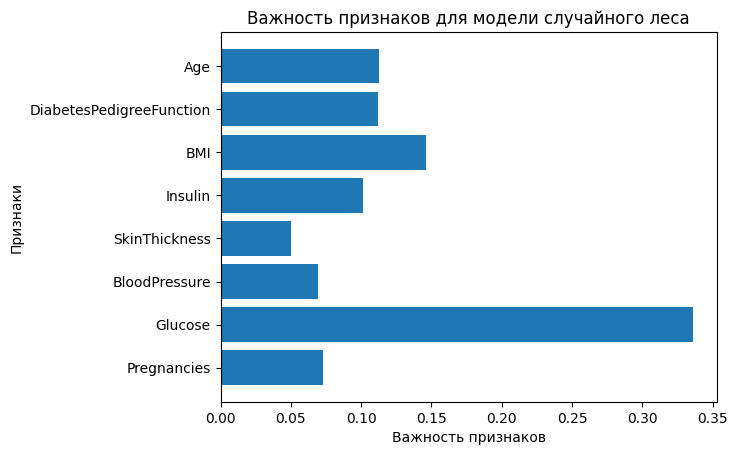

Самый важный признак: Glucose


In [24]:
# Важность признаков
importances = optimized_rf_model.feature_importances_
feature_names = X.columns

# Создаем горизонтальный bar plot
plt.barh(feature_names, importances)
plt.title('Важность признаков для модели случайного леса')
plt.xlabel('Важность признаков')
plt.ylabel('Признаки')
plt.show()

# Определим самый важный признак
most_important = feature_names[np.argmax(importances)]
print(f"Самый важный признак: {most_important}")